In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from collections import Counter
import warnings

warnings.filterwarnings("ignore")


# Airline Passenger Satisfaction Analysis
This dataset contains an airline passenger satisfaction survey. What factors are highly correlated to a satisfied (or dissatisfied) passenger? Can you predict passenger satisfaction? 


In [5]:
train_df = pd.read_csv("test.csv", index_col=0)
train_df.drop("id", axis=1, inplace=True)
test_df = pd.read_csv("train.csv", index_col=0)
test_df.drop("id", axis=1, inplace=True)


In [6]:
train_df.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,1,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,4,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,2,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,3,...,2,2,2,2,4,2,4,0,20.0,satisfied


<a id = "2"></a><br>
# Variable Description
1. id : Unique id number to each passenger.
2. Gender: Gender of the passengers (Female, Male)
3. Customer Type: The customer type (Loyal customer, disloyal customer)
4. Age: The actual age of the passengers
5. Type of Travel: Purpose of the flight of the passengers (Personal Travel, Business Travel)
6. Class: Travel class in the plane of the passengers (Business, Eco, Eco Plus)
7. Flight distance: The flight distance of this journey
8. Inflight wifi service: Satisfaction level of the inflight wifi service (0:Not Applicable;1-5)
9. Departure/Arrival time convenient: Satisfaction level of Departure/Arrival time convenient
10. Ease of Online booking: Satisfaction level of online booking
11. Gate location: Satisfaction level of Gate location
12. Food and drink: Satisfaction level of Food and drink
13. Online boarding: Satisfaction level of online boarding
14. Seat comfort: Satisfaction level of Seat comfort
15. Inflight entertainment: Satisfaction level of inflight entertainment
16. On-board service: Satisfaction level of On-board service
17. Leg room service: Satisfaction level of Leg room service
18. Baggage handling: Satisfaction level of baggage handling
19. Check-in service: Satisfaction level of Check-in service
20. Inflight service: Satisfaction level of inflight service
21. Cleanliness: Satisfaction level of Cleanliness
22. Departure Delay in Minutes: Minutes delayed when departure
23. Arrival Delay in Minutes: Minutes delayed when Arrival
24. Satisfaction: Airline satisfaction level(satisfied, neutral or dissatisfaction)

* int64(18): id, Age,Flight Distance, Inflight wifi service, Departure/Arrival time convenient, Ease of Online booking, Gate location, Food and drink, Online boarding, Seat comfort, Inflight entertainment, On-board service, Leg room service, Baggage handling, Checkin service, Inflight service, Cleanliness and Departure Delay in Minutes.
* object(5): Gender, Customer Type, Type of Travel, Class and satisfaction.
* float64(1): Arrival Delay in Minutes.

<a id = "7"></a><br>
# Outlier Detection


In [7]:
def detect_outliers(df,features):
    outlier_indices=[]
    
    for c in features:
        # 1st quartile
        Q1=np.percentile(df[c],25)
        
        # 3rd quartile
        Q3=np.percentile(df[c],75)
        
        # IQR
        IQR= Q3-Q1
        
        # Outlier Step
        outlier_step= IQR * 1.5
        
        # Detect outlier and their indeces 
        outlier_list_col = df[(df[c]< Q1 - outlier_step)|( df[c] > Q3 + outlier_step)].index
        
        # Store indices 
        outlier_indices.extend(outlier_list_col)
    
    outliers_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i , v in outliers_indices.items() if v>2 )
    return multiple_outliers

In [8]:
train_df.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,1,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,4,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,2,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,3,...,2,2,2,2,4,2,4,0,20.0,satisfied


In [10]:
train_df.loc[
    detect_outliers(
        train_df,
        [
        "Age",
        "Flight Distance",
        "Inflight wifi service",
        "Departure/Arrival time convenient",
        "Ease of Online booking",
        "Gate location",
        "Food and drink",
        "Online boarding",
        "Seat comfort",
        "Inflight entertainment",
        "On-board service",
        "Leg room service",
        "Baggage handling", 'Age', 'Flight_Distance', 'Inflight_wifi_service',
       'Departure/Arrival_time_convenient', 'Ease_of_Online_booking',
       'Gate_location', 'Food_and_drink', 'Online_boarding', 'Seat_comfort',
       'Inflight_entertainment', 'On-board_service', 'Leg_room_service',
       'Baggage_handling', 'Checkin_service', 'Inflight_service',
       'Cleanliness', 'Departure_Delay_in_Minutes',
       'Arrival_Delay_in_Minutes',
        "Checkin service",
        "Inflight service",
        "Cleanliness",
        "Departure Delay in Minutes",
        "Arrival Delay in Minutes",
        ],
    )
]


KeyError: 'Flight_Distance'

In [11]:
# Droping outliers
train_df = train_df.drop(detect_outliers(train_df,[ "Age",
            "Flight Distance",
            "Inflight wifi service",
            "Departure/Arrival time convenient",
            "Ease of Online booking",
            "Gate location",
            "Food and drink",
            "Online boarding",
            "Seat comfort",
            "Inflight entertainment",
            "On-board service",
            "Leg room service",
            "Baggage handling",
            "Checkin service",
            "Inflight service",
            "Cleanliness",
            "Departure Delay in Minutes",
            "Arrival Delay in Minutes",]),axis = 0).reset_index(drop = True)

In [ ]:
train_df.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,1,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,4,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,2,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,3,...,2,2,2,2,4,2,4,0,20.0,satisfied


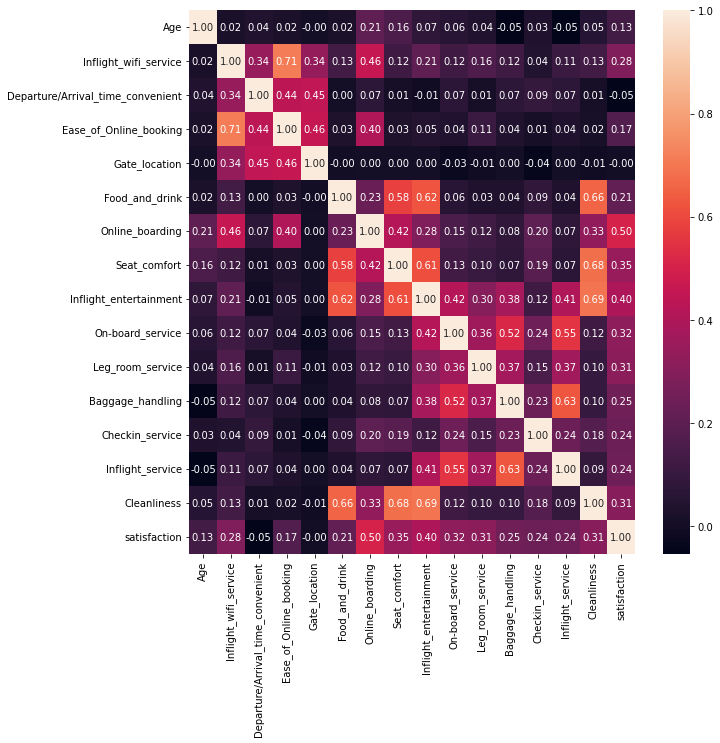

In [ ]:
plt.figure(figsize=(10, 10))
list1 = [
    "Age",
    "Inflight_wifi_service",
    "Departure/Arrival_time_convenient",
    "Ease_of_Online_booking",
    "Gate_location",
    "Food_and_drink",
    "Online_boarding",
    "Seat_comfort",
    "Inflight_entertainment",
    "On-board_service",
    "Leg_room_service",
    "Baggage_handling",
    "Checkin_service",
    "Inflight_service",
    "Cleanliness",
    "satisfaction",
]
sns.heatmap(train_df[list1].corr(), annot=True, fmt=".2f")
plt.show()


<a id = "13"></a><br>
## Gender-->Satisfaction

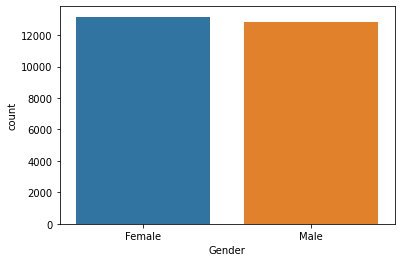

In [23]:
g = sns.countplot(x="Gender",data=train_df)
plt.show()


* Females and males are satisfaction probability almost equal. Male %44, Female %43 satisfaction.


<a id = "14"></a><br>
## Age-->Satisfaction

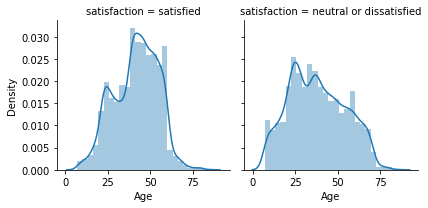

In [24]:
g= sns.FacetGrid(train_df,col="satisfaction")
g.map(sns.distplot,"Age",bins=25)
plt.show()
# 0=neutral or dissatisfied, 1=satisfied 

* 0-20 years old is  generally neutral or dissatisfied with the flight.
* 30-60 years old is generally satisfied with the flight.
* 65-80 years old passengers is neutral or dissatisfied.

<a id = "15"></a><br>
## Customer Type-->Satisfaction

In [26]:
g=sns.factorplot(x="Customer Type",y="satisfaction",data=train_df,kind="bar",size=6)
g.set_ylabels("Satisfaction Probability")
plt.show()

TypeError: Neither the `x` nor `y` variable appears to be numeric.

* Disloyal customer is generally neutral or dissatisfied with the flight.

<a id = "16"></a><br>
## Type of Travel-->Satisfaction

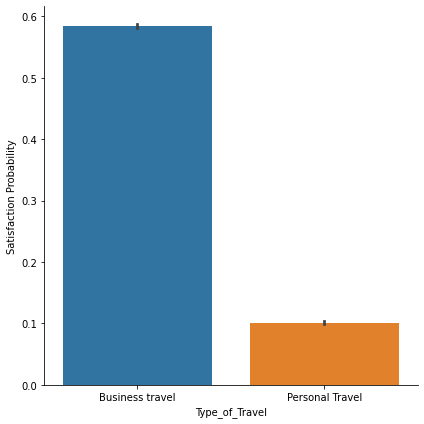

In [ ]:
g=sns.factorplot(x="Type_of_Travel",y="satisfaction",data=train_df,kind="bar",size=6)
g.set_ylabels("Satisfaction Probability")
plt.show()

* Business travel is generally satisfied with the flight but personal travel is generally neutral or dissatisfied with the flight.
* Personal travel is %90 neutral or dissatisfied with the flight. This statistic is interesting.

<a id = "17"></a><br>
## Class-->Satisfaction

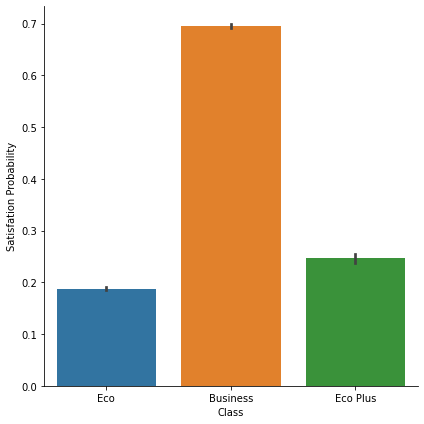

In [ ]:
g = sns.factorplot(x="Class", y="satisfaction", data=train_df, kind="bar", size=6)
g.set_ylabels("Satisfation Probability")
plt.show()


* Business class is also happy here. But eco and eco plus  neutral or dissatisfied with the flight. 

<a id = "22"></a><br>
## Gender-->Age-->Satisfaction

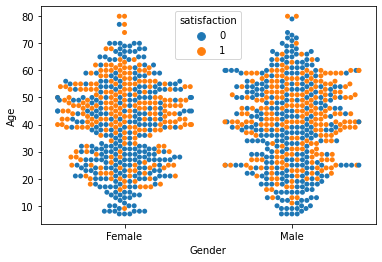

In [ ]:
sns.swarmplot(x="Gender", y="Age",hue="satisfaction", data=train_df.head(1000))
plt.show()
# 0=neutral or dissatisfied, 1=satisfied  